# Signal and Image Processing (SIP_SS24)

### Research Group Neuroinformatics, Faculty of Computer Science,
### University of Vienna


###  Multitapers Tutorial

Lecturer: Prof. Moritz GROSSE-WENTRUP

Tutorial by: Sadiq A. ADEDAYO
$\quad\quad\quad\quad$ Jakob PRAGER 
$\quad\quad\quad\quad$ Kerim ATAK (kerim.atak@univie.ac.at)

#### Aim: Implement multitapers and demonstrate their applications in signal processing.

Multitaper is a time-frequency decomposition (spectral density estimation) method different from Short-Time Fourier Transform (STFT), Wavelet convolution, and Filter Hilbert methods. These three (3) methods, have similar procedures but with different applications. Multitaper differs from these three, but gives approximately the same result. Multitapers smooth signals over frequency and time.


Multitapers are based on `Discrete prolate Slepian tapers (DPSS sequences)`, also known as `Discrete prolate spheroidal sequences (DPSS)`. DPSS are the solutions to eigenvalue problems that we optimized. 

#### The aim is to design a set of optimal windows, such that we can smooth or average the  signal spectrum over a bandwidth of $2w_{s}$ which serves as the constraint for our optimization problem. 

$$\big|X(w)\big| \quad = \quad \frac{1}{k} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w[k] \cdot x[k] \cdot e^{(-jwn)}\Big|$$


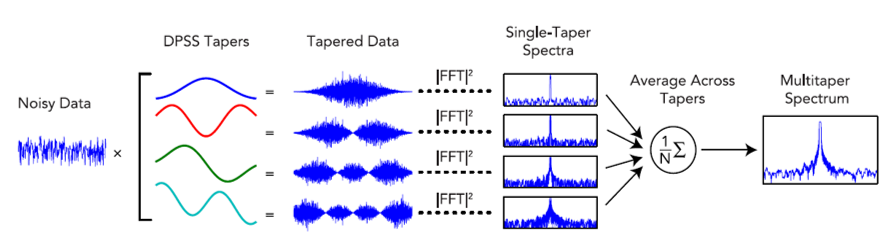


Adapted from [Multitaper toolbox](https://github.com/preraulab/multitaper_toolbox)


Relating results from application of multitapers to that of a `periodogram`, another spectra estimation method (to be covered later in the course). Adapted from [Power spectral analysis using the adaptation of the multitaper method](https://www.researchgate.net/figure/Power-spectral-analysis-using-the-adaptation-of-the-multitaper-method-a-EEG-wave_fig7_355771173)
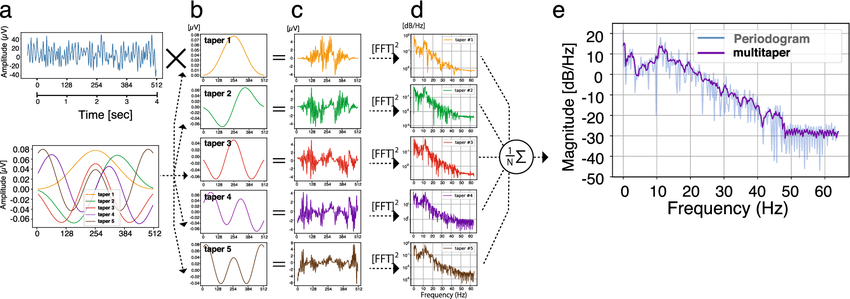

In [1]:
# import packages

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
%matplotlib inline

# To compute the multitapers

The expression is a simple multiplication of a window $w[n]$ with our signal $x[n]$; however, the window must be the same length as the original signal.

$$x[n] \cdot w[n]$$



### Parameters

Assuming a signal/window size $w$ ranging from $\left[-\frac{N}{2}, \dots, \frac{N}{2}\right]$, The length of the signal/window is then given as `N+1`.

$w_{s}$ is the allowable bandwidth/threshold at which the multitaper can smoothen our spectrum

$A$ measures the energy concentration of the multitapers

$$\sum_{n=-\frac{N}{2}}^{\frac{N}{2}}\sum_{m=-\frac{N}{2}}^{\frac{N}{2}} \frac{2sin \left(w_{s}(m - n\right))}{m - n}$$

Recall, the solution to the optimization problem is given as 
$$A.\vec{w} = \lambda^{'} \vec{w}$$

With matrix decomposition: 
$$\vec{w^{T}}A\vec{w} = \lambda^{'}\vec{w^{T}}\vec{w} = \lambda^{'}$$

C:\Users\kerim\AppData\Local\Temp\ipykernel_9368\3324667605.py:11: RuntimeWarning: invalid value encountered in divide
  A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])


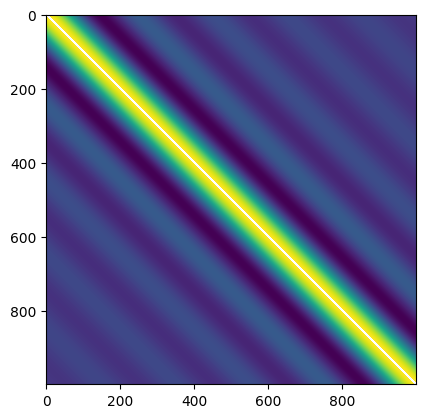

In [2]:
# let N be 1000 in this case

N = 1000
w_s = 0.01*np.pi  # here we selected an allowable threshold of 0.1, this will be tuned afterwards

m = np.arange(N)
n = np.arange(N)

A = np.zeros((N,N))

A = 2 * np.sin(w_s * (n[:,None] - m[None,:])) / (n[:,None] - m[None,:])

# Alternative way to do this
# for mi in m:
#     for ni in n:
#         A[mi, ni] = np.sin(w_s * (ni - mi)) / (ni - mi)

plt.imshow(A)

We filled the diagonals of $A$ with $2w_{s}$ because we encountered some zero division error every time n == m. 

To solve this, we need to fill it with the limit of the function as n approaches m using [$\textbf{L'Hôpital's rule}$](https://en.wikipedia.org/wiki/L%27H%C3%B4pital%27s_rule). 

Recall from the lecture, we constrained our optimization function with $2w_{s}$

(1000, 1000)


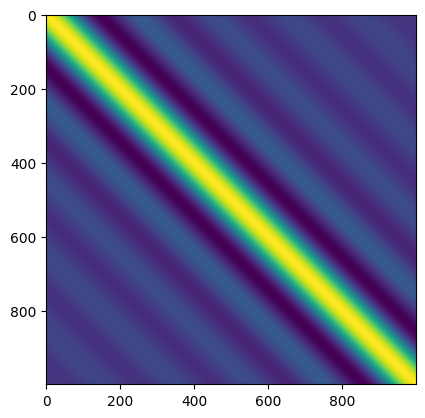

In [3]:
np.fill_diagonal(A, 2*w_s)
print(A.shape)
plt.imshow(A)

Compute eigenvectors

#### Hint: we use np.linalg.eigh(A) because it gives the eigenvectors sorted according to their respective eigenvalue

The eigenvalue plot will enable us to determine the number of eigenvalues that will be useful for selecting eigenvectors (multitapers) for our use. 

We are only interested in those multitapers corresponding to eigenvalues with very high energy concentrations. In simple terms, selecting those eigenvectors means we only consider multitapers with the highest energy concentration.

For the sake of demonstration, I defined a variable `count` as the number of eigenvalues selected and plotted them in red color. 

#### Note: You can toy around with the choice of `count`. 

In [4]:
eig_values, eig_vectors = np.linalg.eigh(A)

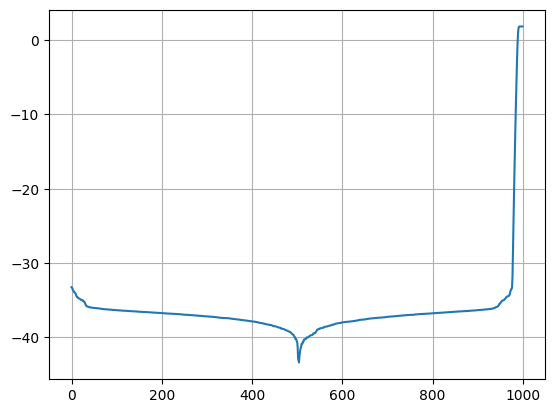

In [5]:
# plot the eigenvalues
plt.plot(np.log(np.abs(eig_values)))
plt.grid()

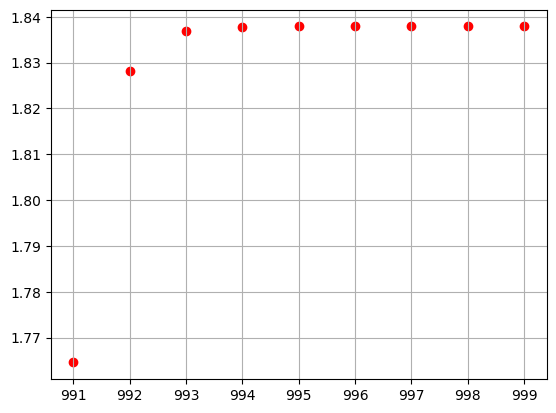

In [6]:
count = 9
plt.scatter(range(N - count, N), np.log(np.abs(eig_values[-count:])), color='red')
plt.grid()

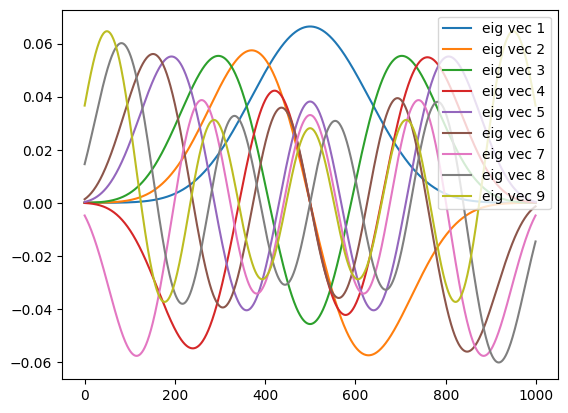

In [7]:
# plot eigeen vecors

for i in range(1,count+1):
    plt.plot(eig_vectors[:,-i],label=f'eig vec {i}')
    plt.legend()

From the plot, we can see that the multitapers are orthogonal and mutually uncorrelated to one another. The first multitaper (with only the first eigenvector) looks precisely Gaussian, and the second one appears as a derivative of the first, and so on. These are not coincidences but rather show the orthogonality of the multitapers. All the individual orthogonal multitapers will then work together as a sequence. The aim is that each of these multitapers will capture or highlight different features in the data.

Now, we can check the efficiency of our selected number of multitapers by taking the Fourier Transform as described below. The efficiency is measured by how the overall multitaper approximates a rectangular window.

$$|X(w)| = \frac{1}{k} \sum_{k = 1}^{K} \Big|\sum_{n=-\frac{N}{2}}^{\frac{N}{2}} w[k] \cdot \color{red} x[k] .\color{black} e^{(-jwn)}\Big|$$

$\color{red}x[k]\color{black}$ is shown in red as it still needs to be plugged in, or it could be thought of as a unit signal for all its durations.


(1000, 1000)


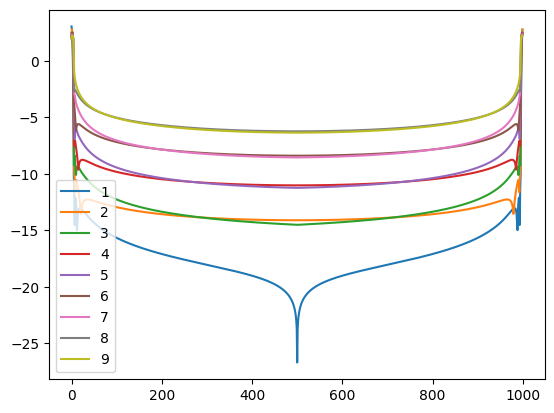

In [8]:
# take fft of eig vectors and plot the mean of the selected count 

Z = np.fft.fft(eig_vectors, axis=0)
#freq = np.fft.fftfreq(N, d=1/(2*np.pi)) # Nyquist freq is pi (in radians )

print(Z.shape)
for i in range(1,count+1):
    plt.plot(np.log(np.mean(np.abs(Z[:,-i:]), axis=1)), label=f'{i}')
    plt.legend()

Plot above shows the resulting window after averaging `count` numbers of eigenvectors

## Scipy implementation

In [9]:
# Multitaper parameters
NW = w_s / (2*np.pi) * N    # Standardized half bandwidth
count = 9           # Number of tapers

# Compute the Slepian sequences (tapers)
tapers, concentration_ratio = windows.dpss(N, NW, count, return_ratios=True)

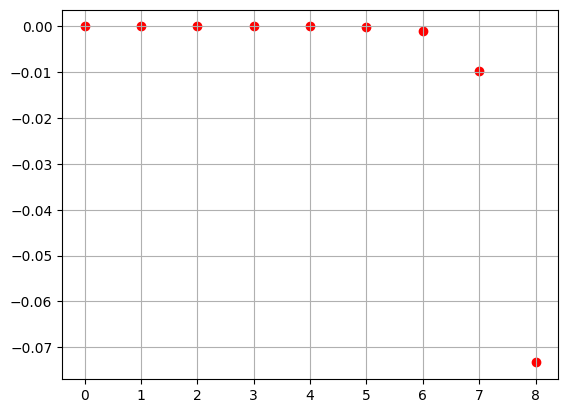

In [10]:
plt.scatter(range(0, count), np.log(np.abs(concentration_ratio[:count])), color='red')
plt.grid()

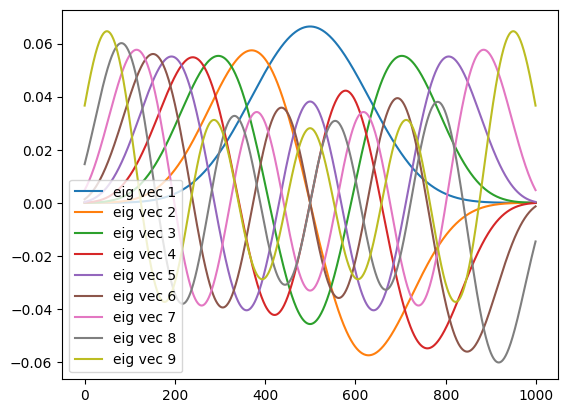

In [11]:
for i in range(0,count):
    plt.plot(tapers[i],label=f'eig vec {i+1}')
    plt.legend()

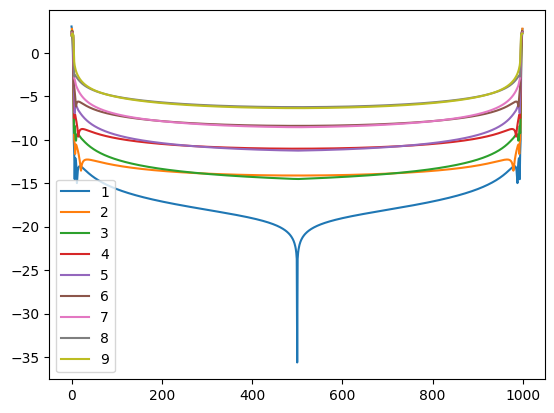

In [12]:
Z = np.fft.fft(tapers, axis=1).T

for i in range(1,count+1):
    plt.plot(np.log(np.mean(np.abs(Z[:, :i]), axis=1)), label=f'{i}')
    plt.legend()

### Bonus tasks

1. Tune the threshold value and discuss its effect on the windows generated.

2. Generate a signal, apply various multitaper counts, and comment on the resolution changes of the frequency spectrums.
